In [192]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Import image

In [194]:
img_1 = cv2.imread('/Users/subhashmishra/Downloads/LLL1.jpeg')
img_2= cv2.imread('/Users/subhashmishra/Downloads/RRR1.jpeg')

In [195]:
# Convert to grayscale
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

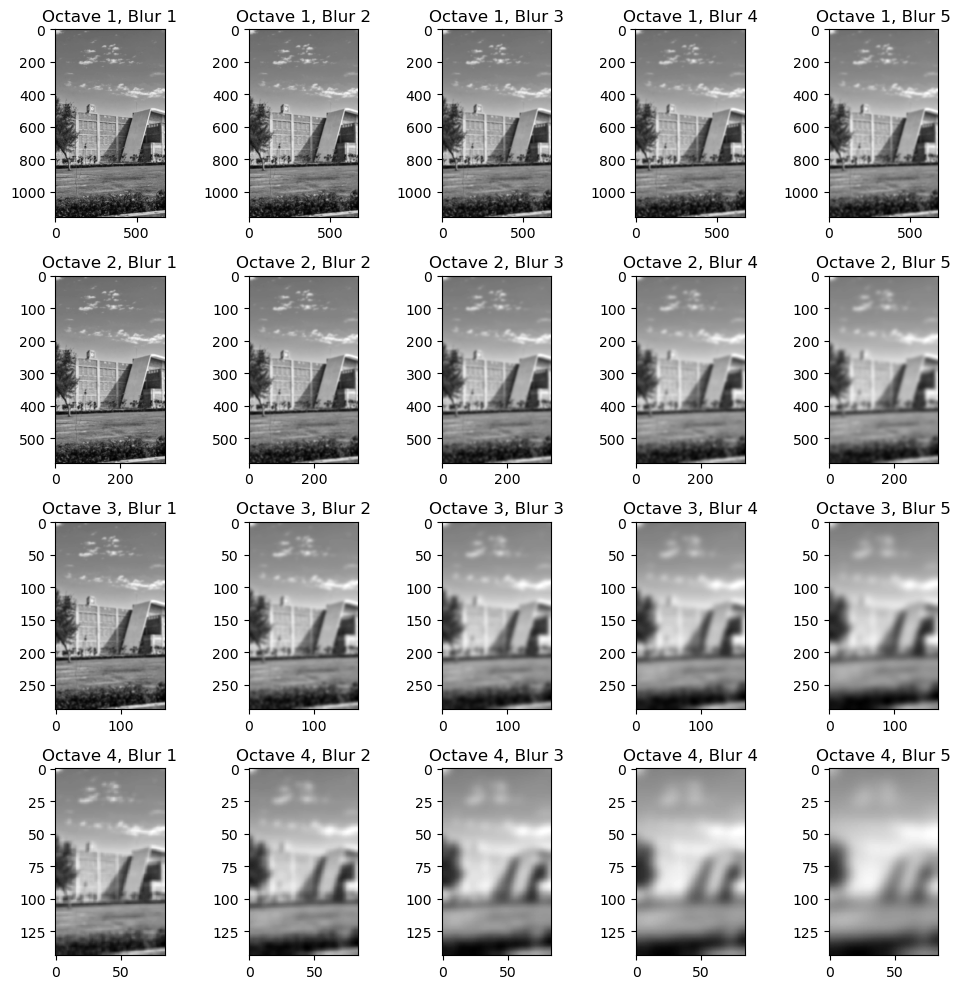

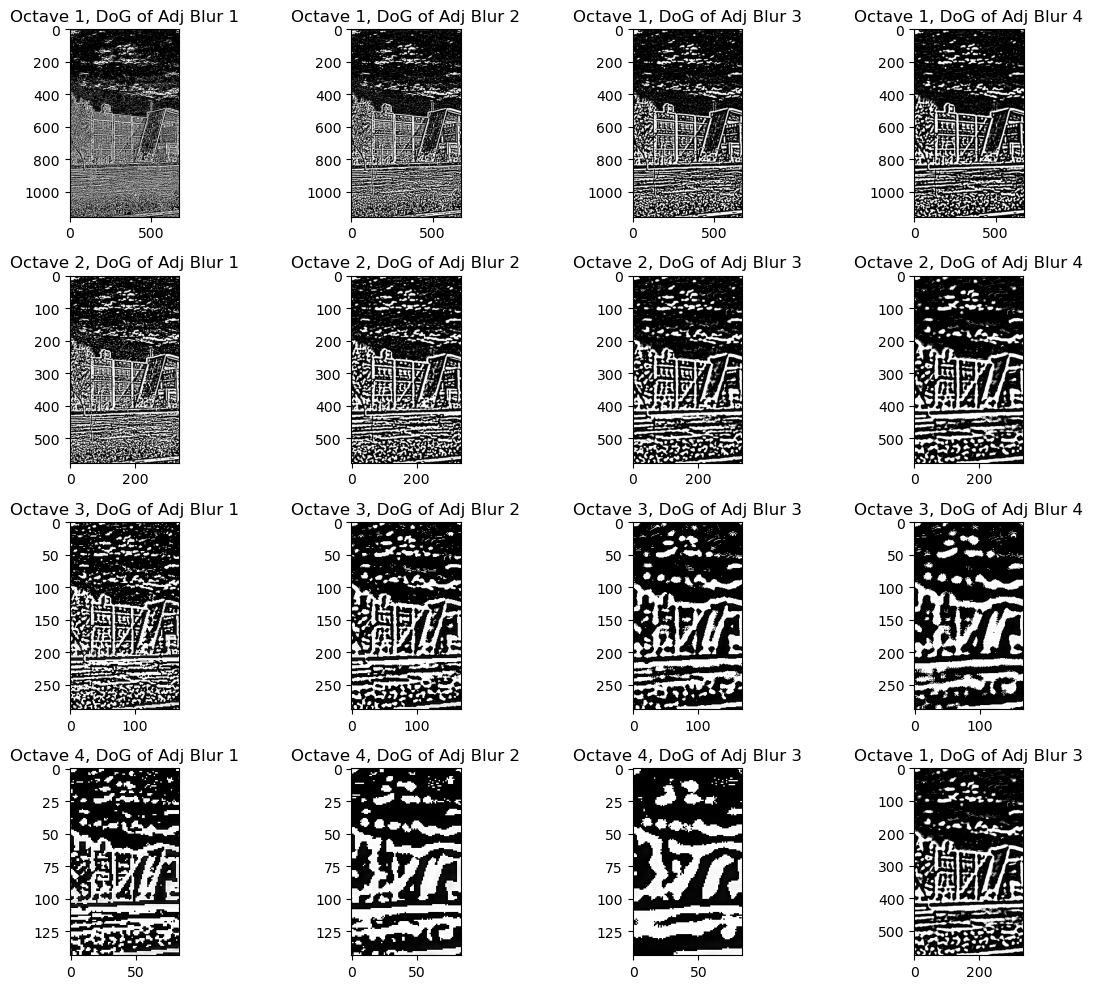

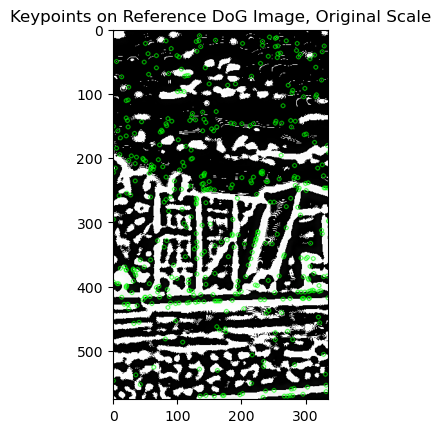

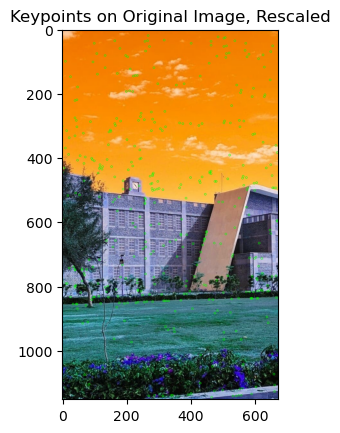

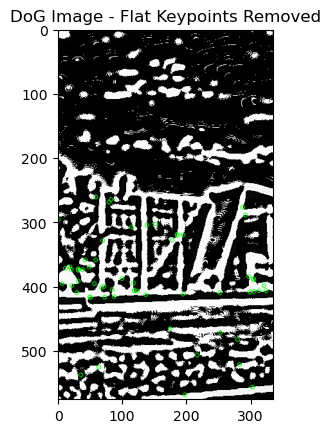

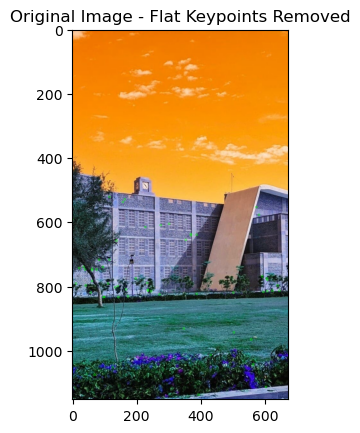

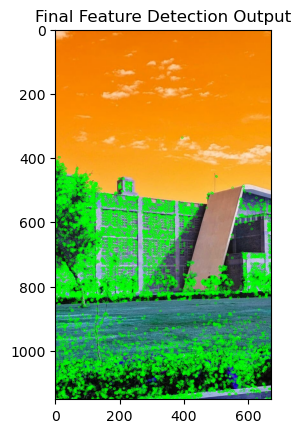

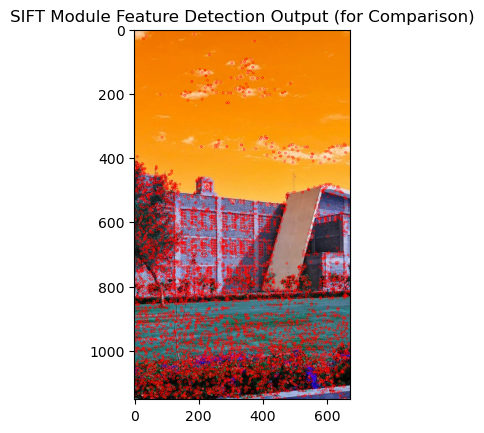

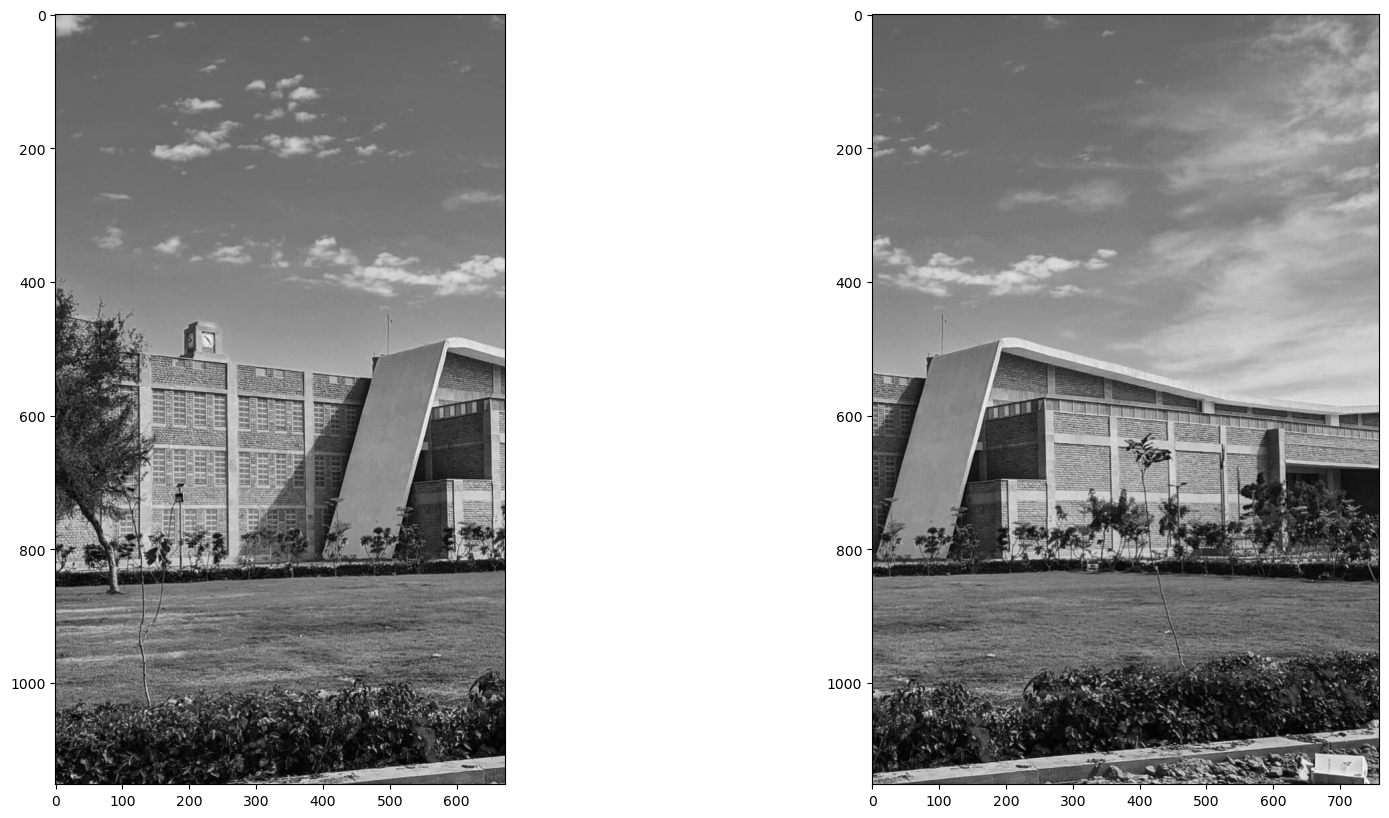

In [196]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].imshow(img_1_gray, cmap='gray')
plots[1].imshow(img_2_gray, cmap='gray')

plt.show()

### Scale Space Extrema Detection

#### Generate Image Pyramid

In [199]:
img = img_1_gray

In [200]:
def quick_resize(img, scale_percent):
    
    # scale_percent - percent of the original image's scale
    
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    return resized

In [201]:
def generate_image_pyramid(img, num_octaves = 4, num_intervals = 5, step_size = 1):
    
    """
    Generate image pyramid for SIFT.
    
    args:
    img - image object
    num_octaves = number of octave (scales)
    num_intervals - number of gaussian operator intervals
    step_size - size of each interval for gaussian operator
    
    out:
    img_pyramid - image pyramid list. each element corresponds to an octave (list), and each element of an octave corresponds to a laplacian image (gaussian blurred)
    """
    
    img_pyramid = []
    imgs_scaled = img

    for i in range(num_octaves):

        # Gaussian Operator parameter
        sigmas = np.arange(1, step_size * (num_intervals + 1), step_size)

        # Create a list of gaussian blurs using different values of sigma parameter
        gaussian_images = []
        for sigma in sigmas:
            gaussian_images.append(cv2.GaussianBlur(imgs_scaled, (0,0), sigma, cv2.BORDER_DEFAULT))

        # Append each list of gaussian images to the main img_pyramid list
        img_pyramid.append(gaussian_images)

        # Scale down image by half the original size
        imgs_scaled = quick_resize(imgs_scaled, 50)
        
    return img_pyramid

In [202]:
img_pyramid = generate_image_pyramid(img)

In [263]:
num_blurs = len(img_pyramid[0])
num_octaves = len(img_pyramid)

fig, ax = plt.subplots(num_octaves, num_blurs, figsize=(2 * num_blurs, 2.5 * num_octaves))

# Plot image pyramid (rows - octaves, columns - blurs)
for i in range(num_octaves):
    for j in range(num_blurs):
        ax[i,j].imshow(img_pyramid[i][j], cmap='gray')
        ax[i,j].set_title(f'Octave {i+1}, Blur {j+1}')

plt.tight_layout()

#### Calculate Difference of Gradients (DoG)

Calculate DoG by subtracting adjacent images within the same octave
![DoG](https://miro.medium.com/v2/resize:fit:828/format:webp/0*DlULvyAuyXb1mSWb.jpg)

In [206]:
def calculate_dog(img_pyramid, num_octaves = 4):
    
    DoG = []
    num_intervals = len(img_pyramid[0])
    num_octaves = len(img_pyramid)

    for i in range(num_octaves):

        DoG_row = []
        for j in range(num_intervals - 1):

            # Subtract images of adjacent intervals within the same octave
            DoG_row.append(img_pyramid[i][j+1] - img_pyramid[i][j])

        DoG.append(DoG_row)
        
    return DoG

In [207]:
DoG = calculate_dog(img_pyramid)

In [208]:
np.array(DoG[0]).shape

(4, 1152, 673)

In [209]:
num_cols = len(DoG[0])
num_rows = len(DoG)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 2.5 * num_rows))

# Plot generated DoG images
for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].imshow(DoG[i][j], cmap='gray')
        ax[i,j].set_title(f'Octave {i+1}, DoG of Adj Blur {j+1}')

plt.tight_layout()

The **DoG** variable now is a 2D list (list of lists). Each element in the list is an Octave (list). And each element in the octave list is a DoG Image.

#### Keypoint Localization

To perform Keypoint Localization, need to define our region of interest. The region of interest, based on the figure below, for any given point are the 9 points above and below, and 8 points surrounding our point of interest, if any. 
![](https://miro.medium.com/v2/resize:fit:466/format:webp/0*nbK933cOIyNrmhWi.jpg)

In [213]:
def get_region_of_interest(octave, DoG_image_index, pixel_coordinates, PRINT_INFO = False):
    
    """
    Gets the region if interest surrounding a point in a 3x3x3 cube, if any.
    
    Args:
        octave - list of DoG images. Each element from this list must be a 2D image of the same dimensions
        DoG_image_index - index to identify current octave
        pixel_coordinate - coordinate of the current pixel being considered
        
    Out:
        prev_octave - region from the prev octave (top of the stack)
        curr_octave - region of the current octave
        next_octave - region of the next octave (bottom of the stack)
    """
    
    pixel_row_index, pixel_col_index = pixel_coordinates

    # Calculate upper and lower bounds (for cases where the point of interest is at the edge or corner of the 3x3x3 cube)
    row_lower_bound = max(0,pixel_row_index - 1)
    row_upper_bound = pixel_row_index + 2
    col_lower_bound = max(0,pixel_col_index - 1)
    col_upper_bound = pixel_col_index + 2

    # If current octave is the top-most of the octave stack
    if DoG_image_index == 0:
        prev_octave = np.array([])
    else:
        prev_octave = octave[DoG_image_index - 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    # If the current octave is at bottom-most of the octave stack
    if DoG_image_index == len(octave) - 1:
        next_octave = np.array([])
    else:
        next_octave = octave[DoG_image_index + 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    curr_octave = octave[DoG_image_index][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    if PRINT_INFO:
        print(f'Previous Octave:\n {prev_octave}\n')
        print(f'Current Octave:\n {curr_octave}\n')
        print(f'Next Octave:\n {next_octave}')
        
    return prev_octave.tolist(), curr_octave.tolist(), next_octave.tolist()

In [214]:
def is_center_pixel_extremum(pixel_value, prev_octave, curr_octave, next_octave):
    
    """
    Checks whether the point of interest / pixel is the extremum (local max or local min) within the provided region of interest
    
    args:
    pixel_value - value of the pixel in the point of interest
    prev_octave, curr_octave, next_octave - region of interest (list)
    
    """
    
    # Concatenate individual regions
    region_of_interest = prev_octave + curr_octave + next_octave

    # Flatten region of interest
    region_of_interest_flatten = [item for sublist in region_of_interest for item in sublist]

    # Check for extremum case
    is_extremum = any(pixel_value == [max(region_of_interest_flatten), min(region_of_interest_flatten)]) and (sum(pixel_value == region_of_interest_flatten) == 1)
    
    return is_extremum

In [215]:
# FOR TESTING PURPOSES
# Sample DoG list of images for testing purposes
sample_octave = np.array([[[7, 4, 2, 3], 
                           [3, 11, 0, 2], 
                           [2, 8, 5, 5]], 
                          
                          [[8, 2, 5, 5], 
                           [3, 0, 9, 7], 
                           [4, 3, 3, 8]],
                          
                          [[2, 7, 1, 9], 
                           [5, 4, 8, 9], 
                           [6, 3, 5, 2]]])


# Test get_region_of_interest()
sample_DoG_image_index = 1
pixel_coordinates = (1,1)
pixel_value = sample_octave[sample_DoG_image_index][pixel_coordinates]

print(f'Pixel Value: {pixel_value}')

prev_octave_sample, curr_octave_sample, next_octave_sample = get_region_of_interest(sample_octave, sample_DoG_image_index, pixel_coordinates)

print(f'Prev Layer: {prev_octave_sample}')
print(f'Curr Layer: {curr_octave_sample}')
print(f'Next Layer: {next_octave_sample}')

Pixel Value: 0
Prev Layer: [[7, 4, 2], [3, 11, 0], [2, 8, 5]]
Curr Layer: [[8, 2, 5], [3, 0, 9], [4, 3, 3]]
Next Layer: [[2, 7, 1], [5, 4, 8], [6, 3, 5]]


In [216]:
# Test is_center_pixel_extremum()
is_center_pixel_extremum(pixel_value, prev_octave_sample, curr_octave_sample, next_octave_sample)

False

#### Keypoint Localization for ONE DoG layer

In [218]:
# Manually define DoG image via octave_index and DoG_image_index
# Generate keypoint for a specific DoG Image
octave_index = 1
DoG_image_index = 3
octave = DoG[octave_index]
DoG_image = octave[DoG_image_index]
plt.imshow(DoG_image,cmap='gray')
plt.title(f'Octave {octave_index}, DoG of Adj Blur {DoG_image_index}')

Text(0.5, 1.0, 'Octave 1, DoG of Adj Blur 3')

In [219]:
keypoints = []

# iterate across DoG images (2d array) in an octave (list)
for pixel_row_index, image_row in enumerate(DoG_image):
    
    # iterate across image rows (1d array) in a DoG image (2d array)
    for pixel_col_index, center_pixel_value in enumerate(image_row):
        
        # get coordinate of point of interest
        center_pixel_coordinate = (pixel_row_index, pixel_col_index)

        # get region of interest
        prev_octave, curr_octave, next_octave = get_region_of_interest(octave, DoG_image_index, center_pixel_coordinate, PRINT_INFO = False)

        # check if point of interest is the extremum of the region of interest
        if is_center_pixel_extremum(center_pixel_value, prev_octave, curr_octave, next_octave):
            
            # append to keypoint output list
            keypoints.append([octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)])

print(len(keypoints))

419


In [220]:
# plot generated keypoits on the DoG image
plt.figure()
raw_keypoint_objects = [cv2.KeyPoint(kp_y, kp_x, 1) for _, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(DoG_image, raw_keypoint_objects,  None, (0, 255, 0)))
plt.title('Keypoints on Reference DoG Image, Original Scale')

# plot generated keypoints on the original image (rescaled)
plt.figure()
keypoint_objects = [cv2.KeyPoint(kp_y * 2**octave_index, kp_x * 2**octave_index, 1) for octave_index, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Keypoints on Original Image, Rescaled')

Text(0.5, 1.0, 'Keypoints on Original Image, Rescaled')

#### Filter Keypoints on ONE DoG Image

Keypoints on FLAT regions have a corresponding low magnitude harris corner response |R| 

Keypoints on EDGE regions have a corresponding negative magnitude harris corner response R

To reject these keypoints, we define a positive threshold value, and only accept keypoints that corresponds to values higher than the threshold value.

(ref: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html)

In [223]:
keypoints_filtered = []
# Set Harris Corner Detection parameters
block_size = 2  # Neighborhood size for corner detection
ksize = 3  # Aperture parameter for Sobel operator
k = 0.03  # Harris corner detection free parameter

# Apply Harris Corner Detection
corners = cv2.cornerHarris(img_1_gray, block_size, ksize, k)

# Threshold for rejecting keypoints on edges and flats
threshold = 0.001 * corners.max()

for i, (_, _, kp) in enumerate(keypoints):
    
    # extract individual keypoint coordinates
    kp_x, kp_y = kp
    
    # Reject Flats and Edges via thresholding the Harris Corner response value
    if corners[kp_x*2**octave_index, kp_y*2**octave_index] > threshold:
        keypoints_filtered.append(keypoints[i])

In [224]:
# plot generated keypoits on the DoG image
plt.figure()
raw_keypoint_objects = [cv2.KeyPoint(kp_y, kp_x, 1) for _, _, (kp_x, kp_y) in keypoints_filtered]
plt.imshow(cv2.drawKeypoints(DoG_image, raw_keypoint_objects,  None, (0, 255, 0)))
plt.title('DoG Image - Flat Keypoints Removed')

# plot generated keypoints on the original image (rescaled)
plt.figure()
rescale_factor = 2**octave_index
keypoint_objects = [cv2.KeyPoint(kp_y * rescale_factor, kp_x * rescale_factor, 1) for _, _, (kp_x, kp_y) in keypoints_filtered]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Original Image - Flat Keypoints Removed')

Text(0.5, 1.0, 'Original Image - Flat Keypoints Removed')

#### Keypoint Localization (Across All DoG Layers + Filtering)

In [226]:
def SIFT_feature_detection(DoG, ref_image, block_size = 2, ksize = 3, k = 0.03, threshold_parameter = 0.001):

    """
    
    args:
    block_size - Neighborhood size for corner detection
    ksize - Aperture parameter for Sobel operator
    k - Harris corner detection free parameter
    
    # Threshold for classifying keypoints as edges or flats
    
    out:
    keypoints - list of keypoints generated via the SIFT algorithm 
              - format: [octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)]
    
    """

    keypoints = []
    
    # Calculate corner coefficient to filter out flats and edges
    # NOTE: not sure whether or not to manually calculate the hessian matrix or to use this library for this purpose
    corners = cv2.cornerHarris(ref_image, block_size, ksize, k)

    # Define threshold
    threshold = threshold_parameter * corners.max()
    
    # iterate across octaves in our DoG list
    for octave_index, octave in enumerate(DoG):

        # iterate across DoG images (2d array) in an octave (list)
        for DoG_image_index, DoG_image in enumerate(octave):

            # iterate across image rows (1d array) in a DoG image (2d array)
            for pixel_row_index, image_row in enumerate(DoG_image):

                # iterate across columns in an image rows
                for pixel_col_index, center_pixel_value in enumerate(image_row):

                    # get coordinate of point of interest
                    center_pixel_coordinate = (pixel_row_index, pixel_col_index)

                    # get region of interest
                    prev_octave, curr_octave, next_octave = get_region_of_interest(octave, DoG_image_index, center_pixel_coordinate, PRINT_INFO = False)

                    # check if point of interest is the extremum of the region of interest 
                    if is_center_pixel_extremum(center_pixel_value, prev_octave, curr_octave, next_octave):

                        # scale pixel coordinates back to the size of the original image
                        scaled_pixel_row_index = pixel_row_index*(2**octave_index)
                        scaled_pixel_col_index = pixel_col_index*(2**octave_index)

                        # Accept only if extremum detected is NOT an flat or edge
                        if corners[scaled_pixel_row_index, scaled_pixel_col_index] > threshold:

                            # append to keypoint output list
                            keypoints.append([octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)])
                            
    return keypoints

In [227]:
keypoints = SIFT_feature_detection(DoG, img, block_size = 2, ksize = 3, k = 0.03, threshold_parameter = 0.001)

In [228]:
plt.figure()
keypoint_objects = [cv2.KeyPoint(kp_y * 2**octave_index, kp_x * 2**octave_index, 1) for octave_index, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Final Feature Detection Output')

plt.figure()
sift = cv2.SIFT_create()
kp_ = sift.detect(img_1_gray,None)
plt.imshow(cv2.drawKeypoints(img_1, kp_,  None, (255, 0, 0)))
plt.title('SIFT Module Feature Detection Output (for Comparison)')

Text(0.5, 1.0, 'SIFT Module Feature Detection Output (for Comparison)')